Using Machine Learning to distinguish the type of traffic, given the traffic will either use a VPN or not.

Each flow is labelled according to the type of traffic.

| Traffic | Content |
|---------|---------|
| Web Browsing | Firefox and Chrome |
| Chat | ICQ, AIM, Skype, Facebook and Hangouts | 
| Streaming | Vimeo and Youtube | 
| Email | SMPTS, POP3S and IMAPS | 
| VoIP |Facebook, Skype and Hangouts voice calls (1h duration) | 
| P2P | uTorrent and Transmission (Bittorrent) |
| FT (File Transfer) | Skype, FTPS and SFTP using Filezilla and an external service | 



## Setup - Provided by the Open university

This imports the required libraries and loads the data into training, validation, and testing datasets.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, metrics, Sequential, utils

import os
import json

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML, display

## Loading and preparing the dataset - Provided by the Open university

This section of the notebook loads the dataset and makes it available for training.

First, we define some constants we will use later and define some metrics to use for model evaluation.

In [2]:
BATCH_SIZE = 64

In [3]:
class_names = {i: n.strip() for i, n in enumerate(open('/datasets/cybersecurity/vpn-nonvpn/class_names.txt'))}
class_names

{0: 'BROWSING',
 1: 'CHAT',
 2: 'STREAMING',
 3: 'MAIL',
 4: 'VOIP',
 5: 'P2P',
 6: 'FT'}

In [4]:
class_names_array = np.array([class_names[i] for i in sorted(class_names)])
class_names_array

array(['BROWSING', 'CHAT', 'STREAMING', 'MAIL', 'VOIP', 'P2P', 'FT'],
      dtype='<U9')

In [5]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan=10}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for cn in class_names.values():
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += '<th rowspan=11>Actual labels</th>\n'

    for ai, an in class_names.items(): # enumerate(class_names):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in class_names.items(): #enumerate(class_names):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

In [6]:
def multi_class_precision(cmatrix):
    s = cmatrix.shape[0]
    numerator = tf.reduce_sum(tf.linalg.diag(tf.ones(s)) * cmatrix, axis=0)
    denominator = tf.cast(tf.reduce_sum(cmatrix, axis=0), tf.float32)
    return numerator / denominator

In [7]:
def multi_class_recall(cmatrix):
    s = cmatrix.shape[0]
    numerator = tf.reduce_sum(tf.linalg.diag(tf.ones(s)) * cmatrix, axis=1)
    denominator = tf.cast(tf.reduce_sum(cmatrix, axis=1), tf.float32)
    return numerator / denominator

Where to find the data.

In [8]:
base_dir = '/datasets/cybersecurity/vpn-nonvpn/'

In [9]:
train_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_train'))
train_vpn_data = train_vpn_data.cache()
train_vpn_data = train_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_vpn_data = train_vpn_data.shuffle(1000)
train_vpn_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [10]:
validation_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_validation'))
validation_vpn_data = validation_vpn_data.cache()
validation_vpn_data = validation_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
validation_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [11]:
test_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_VPN_test'))
test_vpn_data = test_vpn_data.cache()
test_vpn_data = test_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [12]:
train_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_train'))
train_no_vpn_data = train_no_vpn_data.cache()
train_no_vpn_data = train_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
train_no_vpn_data = train_no_vpn_data.shuffle(1000)
train_no_vpn_data

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [13]:
validation_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_validation'))
validation_no_vpn_data = validation_no_vpn_data.cache()
validation_no_vpn_data = validation_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
validation_no_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [14]:
test_no_vpn_data = tf.data.Dataset.load(os.path.join(base_dir, 'scenario_a2_15s_NO-VPN_test'))
test_no_vpn_data = test_no_vpn_data.cache()
test_no_vpn_data = test_no_vpn_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
test_no_vpn_data

<_ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 23), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.int64, name=None))>

In [15]:
input_shape = (train_vpn_data.element_spec[0].shape[1],)
num_classes = train_vpn_data.element_spec[1].shape[1]
input_shape, num_classes

((23,), 7)

## Validation and test labels - Provided by the Open university

Use these for generating confusion matrices.

In [16]:
validation_vpn_labels = np.array(list(validation_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_vpn_labels = np.argmax(validation_vpn_labels, axis=1)
validation_vpn_labels.shape

(979,)

In [17]:
validation_no_vpn_labels = np.array(list(validation_no_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
validation_no_vpn_labels = np.argmax(validation_no_vpn_labels, axis=1)
validation_no_vpn_labels.shape

(896,)

In [18]:
test_vpn_labels = np.array(list(test_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_vpn_labels = np.argmax(test_vpn_labels, axis=1)
test_vpn_labels.shape

(1958,)

In [19]:
test_no_vpn_labels = np.array(list(test_no_vpn_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_no_vpn_labels = np.argmax(test_no_vpn_labels, axis=1)
test_no_vpn_labels.shape

(1792,)

# Models

A first model for traffic that has come through a VPN

In [ ]:

# Create the model
model_a = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# get the summary of the model and check it
model_a.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,007 (31.28 KB)

 Trainable params: 8,007 (31.28 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Set opt
opt = optimizers.RMSprop()
model_a.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
history = model_a.fit(train_vpn_data,
                    validation_data=validation_vpn_data,
                    epochs=200,
                    verbose=0
                   )
                    

I0000 00:00:1731771323.498049    9180 service.cc:145] XLA service 0x7f0e20084090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731771323.498084    9180 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731771324.215824    9180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [23]:
# save model and training history and reload them
model_a.save('model_a.keras')
model_a = tf.keras.models.load_model('model_a.keras')

with open('model_a_history.json', 'w') as f:
    json.dump(history.history, f)

with open('model_a_history.json') as f:
    sample4_history = json.load(f)

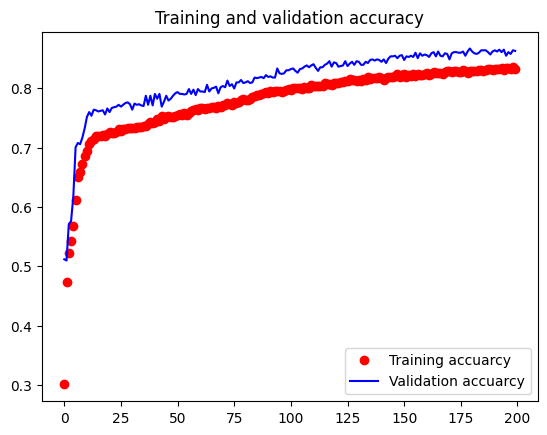

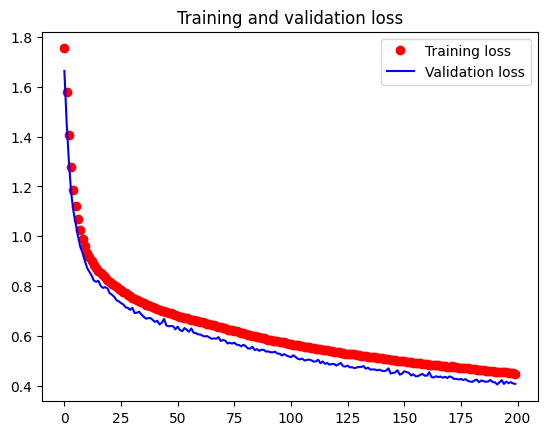

In [24]:
# Plot the graph of the history
# accuracy graph
acc = sample4_history['accuracy']
val_acc = sample4_history['val_accuracy']
loss = sample4_history['loss']
val_loss = sample4_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training accuarcy')
plt.plot(epochs, val_acc, 'b', label='Validation accuarcy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Loss graph
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Comment on graphs
> The accuracy increases and the loss decreases over the course of the training.
> Even at 200 epochs, the accuracy is still increasing at above 85% and the loss is still decreasing at just below 0.4.
> 
> This suggests the model may benefit from more training to reach an optimal point, and that over-fitting has not occurred. In fact the loss is starting to reach its optimal point.
>
> The validation data appears to be better than the training data, this could be down to the distribution of the data.
>  

In [26]:
# Evaluate on the test data
model_a.evaluate(test_vpn_data, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.8320 - loss: 0.4725


{'accuracy': 0.8396322727203369, 'loss': 0.44960716366767883}

comment on evaluation:
> The accuracy is 0.84 showing that the model is doing well. The loss of the model is 0.47.

In [27]:
# Generate predictions
test_predictions = model_a.predict(test_vpn_data)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [28]:
# Generate predicted and actual labels for confusion matrix
predict_labels = np.argmax(test_predictions, axis=1)

In [29]:
# Generate confusion matrix
cmatrix_a = tf.math.confusion_matrix(test_vpn_labels, predict_labels).numpy()
pretty_cm(cmatrix_a)

Comment on confusion matrix:
> This confusion matrix shows a high degree of accuracy.
>
> However there are some areas where the numbers are high where they shouldn't be. It is clear that 'browsing' can is predicted when 'chat' is the actual label 17% of the time. 'FT' is also predicted 23% of the time when the actual label is 'chat'.

A first model for data that has not come through a VPN

In [ ]:

# Create the model
model_b = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='sigmoid'), 
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [31]:
# Set the opt
opt = optimizers.RMSprop()
model_b.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [32]:
history = model_b.fit(train_no_vpn_data,
                      validation_data=validation_no_vpn_data,
                      epochs=200,
                      verbose=0
                     )

In [33]:
# Save the model and training history then reload them
model_b.save('model_b.keras')
model_b = tf.keras.models.load_model('model_b.keras')

with open('model_b_history.json', 'w') as f:
    json.dump(history.history, f)

with open('model_b_history.json') as f:
    sample5_history = json.load(f)

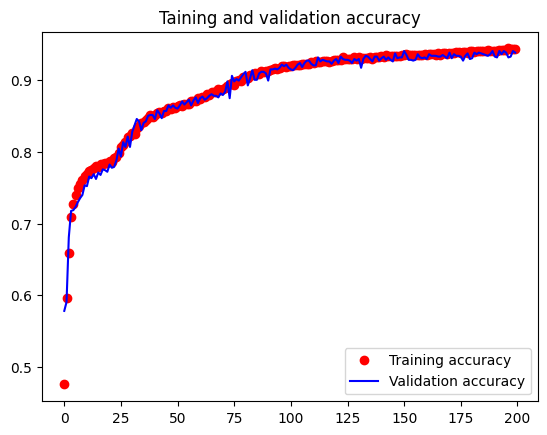

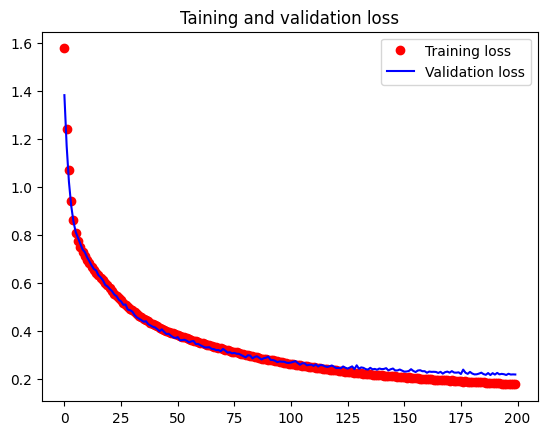

In [34]:
# Plot the graph of the history

acc = sample5_history['accuracy']
val_acc = sample5_history['val_accuracy']
loss = sample5_history['loss']
val_loss = sample5_history['val_loss']

epochs = range(len(acc))

# Accuracy and loss graphs
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Taining and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Taining and validation loss')
plt.legend()

plt.show()

Comment on graphs:
> The loss graph suggests the model is starting to show very early signs of over-fitting.
>
> At around 150 epochs the loss, starts to level out. This means the difference between the training loss and the validation loss is increasing, suggesting an optimal point has already been reached.
>
> The graphs indicate a high level of accuracy, above 90% and the loss is around 0.2.

In [35]:
# Evaluate on the test data set
model_b.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9428 - loss: 0.1979  


{'accuracy': 0.9391741156578064, 'loss': 0.1980825662612915}

Comment on evaluation:
> This is more accurate than the previous model as it has 0.94 and the loss is more than half the vpn data at 0.20

In [36]:
# Generate predictions
test_predictions_b = model_b.predict(test_no_vpn_data)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [37]:
# Generate predicted and actual labels for confusion matrix
predict_labels_b = np.argmax(test_predictions_b, axis=1)

In [38]:
# Generate confusion matrix
cmatrix_b = tf.math.confusion_matrix(test_no_vpn_labels, predict_labels_b).numpy()
pretty_cm(cmatrix_b)

Comment on the confusion matrix:
> This is more accurate than the previous model.
>
> 'browsing' is still sometimes incorrectly predicted when it should be 'chat', however this value is now at 15%, which is lower than then 17% in the previous model.
> 
> There are very few errors in the table, which lines up with the 94% evaluation above.

Compare The above results to those presented by Draper-Gil _et al._ (2016)

Comments:

>
> The model trained on non-VPN traffic more accurate as it has a accuracy of 93% compared with the VPN traffic which has an accuracy of 83%.
>
> The model trained on non-VPN traffic also has a lower loss, at 0.20 compared with 0.45 on the VPN traffic.

In [ ]:
# model_a results
# generate precision scores
multi_class_precision(cmatrix_a)

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.85046726, 0.6797753 , 0.9148936 , 0.7586207 , 0.9955457 ,
       0.80864197, 0.745283  ], dtype=float32)>

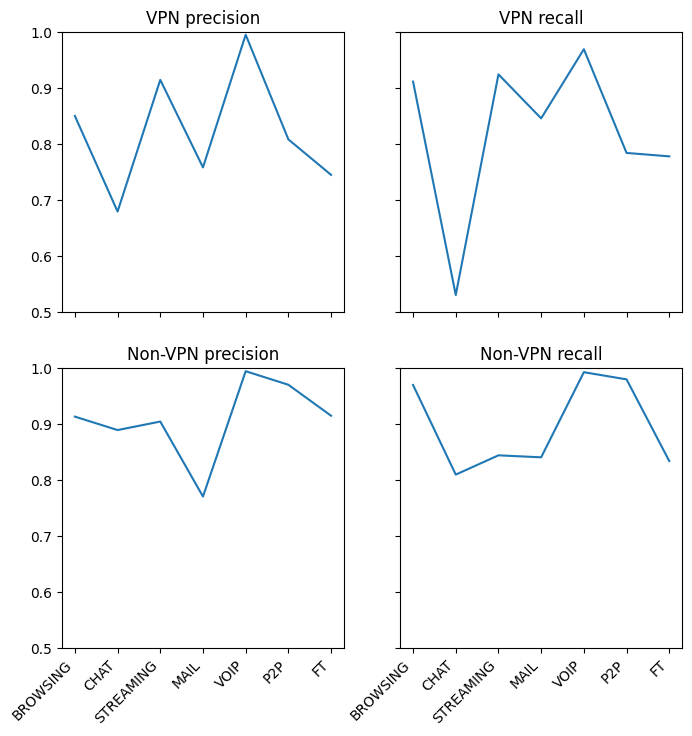

In [42]:
fig = plt.figure(figsize=(8, 8))
ax = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

ax[0, 0].plot(class_names_array, multi_class_precision(cmatrix_a).numpy())
ax[0, 0].set_title("VPN precision")
ax[0, 0].grid(axis='y')

# Add plot here
ax[0, 1].plot(class_names_array, multi_class_recall(cmatrix_a).numpy())
ax[0, 1].set_title("VPN recall")
ax[0, 0].grid(axis='y')

# Add plot here
ax[1, 0].plot(class_names_array, multi_class_precision(cmatrix_b).numpy())
ax[1, 0].set_title("Non-VPN precision")
ax[0, 0].grid(axis='y')

# Add plot here
ax[1, 1].plot(class_names_array, multi_class_recall(cmatrix_b).numpy())
ax[1, 1].set_title("Non-VPN recall")
ax[0, 0].grid(axis='y')

ax[1, 0].set_xticks(class_names_array, labels=class_names_array, rotation=45, horizontalalignment='right')
ax[1, 1].set_xticks(class_names_array, labels=class_names_array, rotation=45, horizontalalignment='right')
ax[1, 1].set_ylim((0.5, 1.0))
plt.show()

Comments on graph compared with Draper-Gil et al. (2016): 

> It is somewhat hard to compare these results acurately as there are two lines on the graph that represent the 15s data that we are interested in.
>
>  The Precision with VPN results are very similar to that of the Draper-Gil results. With a range of results between 0.6 and 1. All Plots along the graph are similar.
>
> Precision without VPN results are very similar to one of the 15s plots on the Draper-Gil graph, following a similar pattern. However, The second line shows results that are quite different. Esspecially in the 'CHAT' data, my graph suggests around 0.85, whereas the Draper-Gil graph is round 0.68.
>
> Recall with VPN results are fairly similar, however 'chat' performs far worse in my model than Draper-Gil's. My data gives a value around 0.55, and Draper-Gils results are between 0.62 and 0.68.
>
> Recall without VPN results somewhat similar to that of those recorded in the Draper-Gil paper. The Chat, streaming and mail results do display a difference to one of the sets of data recorded by Draper-Gil.
>

### Improvements

Make improvements to the first two models and compare them against the first two created.

In [43]:
# Your solution here
# Use additional cells as needed.

# Create the model d1
model_d1 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])




In [44]:
# Set the opt, loss and metrics for model_d1
model_d1.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'])


In [45]:
# Train model_d1
history_d1 = model_d1.fit(train_vpn_data,
                          validation_data=validation_vpn_data,
                          epochs=300,
                          verbose=0)
                          

In [46]:
# save model_d1
model_d1.save('model_d1.keras')

with open('model_d1_history.json', 'w') as f:
    json.dump(history_d1.history, f)

In [47]:
# reload the model_d1
model = tf.keras.models.load_model('model_d1.keras')

with open('model_d1_history.json') as f:
    sample6_history = json.load(f)

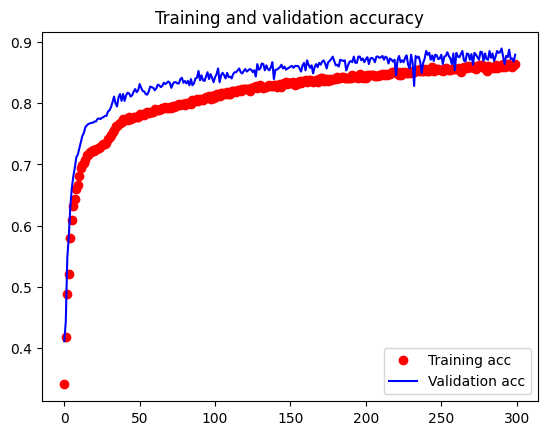

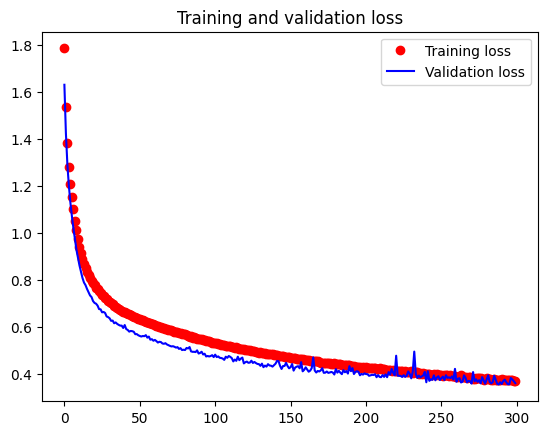

In [48]:
# Plot accuracy and loss graphs

acc = sample6_history['accuracy']
val_acc = sample6_history['val_accuracy']
loss = sample6_history['loss']
val_loss = sample6_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

comment on graphs:
>
> These graphs imply good classification and good learning with no signs of over-fitting.
>
> The model reaches an accuracy of nearly 90% showing the model is learning well.
>
> The model also reaches a loss of around 0.4.

In [49]:
# Evaluate the model on training data
model_d1.evaluate(train_vpn_data, return_dict=True)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8686 - loss: 0.3480


{'accuracy': 0.8710618615150452, 'loss': 0.3508884310722351}

In [50]:
# Evaluate the model on validation data
model_d1.evaluate(validation_vpn_data, return_dict=True)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8966 - loss: 0.3223


{'accuracy': 0.8794688582420349, 'loss': 0.35961830615997314}

comment on evaluation:

> The accuracy is of a very acceptable value at 87% for both the validation and training data. The loss values for training and validation data are 0.35 and 0.36 respectively. Indicating the validation data is working better than the training data. This could again be down to the distribution of the data.
> 
> The graph hasn't quite started to level out, so this model could benefit from more training.

In [51]:
# Generate predictions
test_predictions_d1 = model_d1.predict(test_vpn_data)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [52]:
# Generate predicted and actual labels for confusion matrix
predict_labels_d1 = np.argmax(test_predictions_d1, axis=1)

In [53]:
# Generate confusion matrix
cmatrix_d1 = tf.math.confusion_matrix(test_vpn_labels, predict_labels_d1).numpy()
pretty_cm(cmatrix_d1)

Comment on confusion matrix:
> This shows model_d1 is a good model, for most of the labels.
>
> However, the model performs incorrectly predicts the 'ft' label 12% of the time and incorrectly predicts the 'browsing' label 16% of the time when it should be labeled 'chat'. In fact of all the data that should be labaled 'chat', the prediction is incorrect 37% of the time.
>
> The model also incorrectly labels 'P2P' data as 'FT' 12% of the time. 

In [54]:
# Create the model d2
model_d2 = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [55]:
# Set the opt, loss and metrics for model_d2
model_d2.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
# Train model_d2
history_d2 = model_d2.fit(train_no_vpn_data,
                          validation_data=validation_no_vpn_data,
                          epochs=300,
                          verbose=0)

In [57]:
# save model_d2
model_d2.save('model_d2.keras')

with open('model_d2_history.json', 'w') as f:
    json.dump(history_d2.history, f)

In [58]:
# reload the model_d2
model_d2 = tf.keras.models.load_model('model_d2.keras')

with open('model_d2_history.json') as f:
    sample7_history = json.load(f)

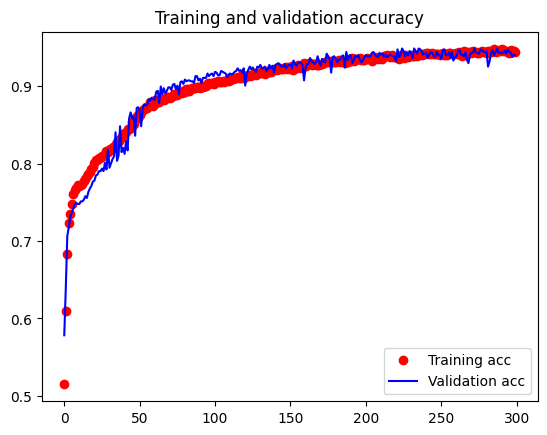

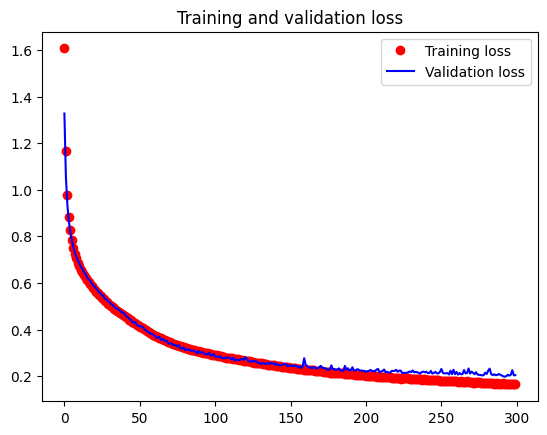

In [59]:
# Plot accuracy and loss graphs

acc = sample7_history['accuracy']
val_acc = sample7_history['val_accuracy']
loss = sample7_history['loss']
val_loss = sample7_history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Comment of graphs:
>
> Starts to level out around 200-250 epochs  for loss and at around 150 for accuracy, so perhaps doesn't need as much training as it is currently having.
> Especially as the loss curves for the training loss and the validation loss start to get further apart.
>
> The loss reaches a value of around 0.2 and the accuracy passes above 90%. This shows the model is getting very good at making predictions. 

In [60]:
# Evaluate the model on training data
model_d2.evaluate(train_no_vpn_data, return_dict=True)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9490 - loss: 0.1522


{'accuracy': 0.9466305375099182, 'loss': 0.1586485356092453}

In [61]:
# Evaluate the model on validation data
model_d2.evaluate(validation_no_vpn_data, return_dict=True)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.9425 - loss: 0.2106


{'accuracy': 0.9397321343421936, 'loss': 0.20396003127098083}

Comment on the evaluation of the model:
>
> This is a really good level of accuracy at 95% for training data and 94% for validation data.
>
> The loss of around is now at 0.16 for training data, however that does increase to 0.20 for the validation data which is to be expected.

In [62]:
# Generate predictions
test_predictions_d2 = model_d2.predict(test_no_vpn_data)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [63]:
# Generate predicted and actual labels for confusion matrix
predict_labels_d2 = np.argmax(test_predictions_d2, axis=1)

In [64]:
# Generate confusion matrix
cmatrix_d2 = tf.math.confusion_matrix(test_no_vpn_labels, predict_labels_d2).numpy()
pretty_cm(cmatrix_d2)

comment on confusion matrix
>
> Training graph is saying that the model is working well, and this confusion matrix shows it working brilliantly well with test data. Highlighted by very few errors. The highest percentage error for one of the labels is when 'browsing' is mistakenly predicted instead of 'chat' which is only 6%
>
>
> The graphs and confusion matrix for this model, far outperform the graphs for model_d1. The errors or the 'chat' labels have decreased from 37% to 11%. 


comment on overall, compared with (a) and (b)
>
> Model_d1 is much closer to being as effective as those in parts a and b. However model_d2 is much more effective than those in parts a and b. This is highlighted as there are fewer errors in the confusion matrix for model_d2 than model_d1.
>
> The model training the no VPN data, in the second part of this question (model_d2) is best suited for this data.

# Part e (3 marks)

 How well do the improved models  work on the dataset it wasn't trained on? ie. the models trained on VPN data, tested against non VPN data and visa versa.

In [93]:
# Evaluate the model
model_d1.evaluate(test_vpn_data, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8429 - loss: 0.4161


{'accuracy': 0.8539325594902039, 'loss': 0.3994064927101135}

In [94]:
# Evaluate the model_d2 on test data
model_d2.evaluate(test_no_vpn_data, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.1907


{'accuracy': 0.9308035969734192, 'loss': 0.19991502165794373}

Comments:
>
> Model_d1 is performing in a similar fashion to when it was looking at the validation and test data. It has an accuracy of 0.85 and a loss of 0.40.
>
> Model_d2 performs equally as well as on the training and validation data as with this test data. With an accuracy of 0.93 and a loss of 0.2.
>
> Both models perform well on the test_data. However, Model_d2 performs best, with an accuracy nearly 10% higher and a loss 0.199 lower.

combine the `vpn` and `no_vpn` datasets and classify the flows when they are a mixture of VPN and non-VPN traffic


In [65]:
train_all_data = train_vpn_data.concatenate(train_no_vpn_data)
train_all_data = train_all_data.shuffle(200)

validation_all_data = validation_vpn_data.concatenate(validation_no_vpn_data)

test_all_data = test_vpn_data.concatenate(test_no_vpn_data)

test_all_labels = np.array(list(test_all_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_all_labels = np.argmax(test_all_labels, axis=1)

In [66]:
# Your solution here
# Use additional cells as needed.

# Create the model
model_f = tf.keras.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [67]:
# Set the optimiser, loss and metrics
model_f.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [68]:
history_f = model_f.fit(train_all_data,
                        validation_data=validation_all_data,
                        epochs=300,
                        verbose=0)

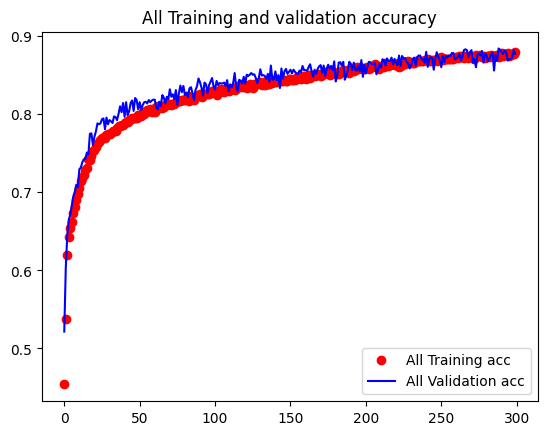

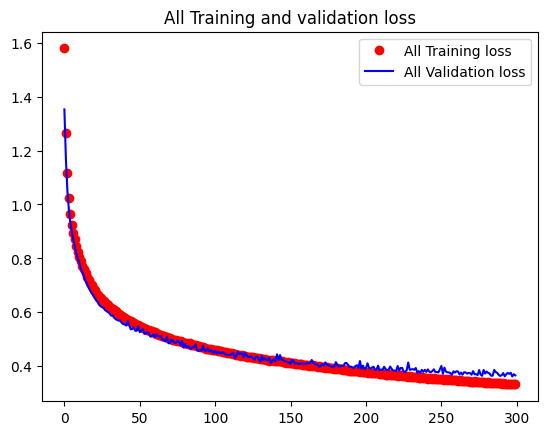

In [69]:
acc = history_f.history['accuracy']
val_acc = history_f.history['val_accuracy']
loss = history_f.history['loss']
val_loss = history_f.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='All Training acc')
plt.plot(epochs, val_acc, 'b', label='All Validation acc')
plt.title('All Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='All Training loss')
plt.plot(epochs, val_loss, 'b', label='All Validation loss')
plt.title('All Training and validation loss')
plt.legend()

plt.show()

In [70]:
# Evaluate the model
model_f.evaluate(test_all_data, return_dict=True)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.4153


{'accuracy': 0.8810666799545288, 'loss': 0.35832446813583374}

In [71]:
# generate predictions for a confusion matrix
test_predictions_f = model_f.predict(test_all_data)
# generate predicted labels
predict_labels_f = np.argmax(test_predictions_f, axis=1)

# Generate confusion matrix
cmatrix_f = tf.math.confusion_matrix(test_all_labels, predict_labels_f).numpy()
pretty_cm(cmatrix_f)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Comment on the confusion matrix compared next to the previous matrices.

> This confusion matrix is very accurate in some places and less accurate in others. The 'chat' data is incorrectly labeled 30% of the time, mainly as 'browsing' and 'ft', 15% and 6% respectively. The 'ft' data is incorrectly labeled 24% of the time, mainly as 'chat', which happens 9% of the time and 'P2P', which happens 7% of the time.
>
> All of the models find the 'chat', 'browsing' and 'ft' labels hardest to predict, however the No VPN dataset does this the best with a error percentage of 11%, compared with 30% for the all data and 37% for the VPN data.
>
> The No VPM data is the best, highlighted by an accuracy of 93% and a loss of  0.2. This dataset makes the fewest errors.
>
> All data is the second best dataset on using this model with an accuracy only slightly lower, at 0.88. However this models experiences greater loss, at 0.35.
>
> The VPN dataset is the worst of the three, while the accuracy is only slightly lower than the model working with All the data,  its loss is a big increase on the NO VPM data and a small increase on the NO NPM dataset.
>
> As a result, this model best performs on the NO VPM dataset.